# Import Library & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET_PATH = '../data/cleaned_data_saudi_used_cars.csv'
DATASET_OUTPUT_PATH = '../data/filtered_data_saudi_used_cars.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)
print("Loaded shape:", df.shape)
display(df.head())

Loaded shape: (3824, 11)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         3824 non-null   object 
 1   Region       3824 non-null   object 
 2   Make         3824 non-null   object 
 3   Gear_Type    3824 non-null   object 
 4   Origin       3824 non-null   object 
 5   Options      3824 non-null   object 
 6   Year         3824 non-null   int64  
 7   Engine_Size  3824 non-null   float64
 8   Mileage      3824 non-null   int64  
 9   Negotiable   3824 non-null   bool   
 10  Price        3824 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 302.6+ KB


# Exploratory Data Analysis (EDA) - Detailed Features Exploration

In this section, I'll explore each feature in more detail to understand more about the data

## Helper Functions for Visualization

For Numerical:

In [ ]:
def plot_hist(series, bins, title, xlabel):
    plt.figure(figsize=(10, 5))
    sns.histplot(series, bins=bins, kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def plot_box(series, title, xlabel):
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=series, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

For Categorical:

In [76]:
def top_n_barplot(series, n=20, title=None, xlabel=None):
    counts = series.value_counts()
    plt.figure(figsize=(12, 6))
    counts.head(n).plot(kind='bar')
    plt.title(title or f'Top {n} Most Common')
    plt.ylabel('Count')
    plt.xlabel(xlabel or series.name)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    print("\nTop 20 most common Types:")
    print(counts.head(n))

def find_near_duplicates(series):
    raw = pd.Series(series.unique())
    suspect = raw[raw.str.strip().str.lower().duplicated(keep=False)]
    print(f"Possible near-duplicate or inconsistent names:\n{suspect}")

def pareto_coverage(series, target_pct=0.8):
    counts = series.value_counts()
    cumsum = counts.cumsum() / counts.sum()
    N_target = (cumsum >= target_pct).argmax() + 1
    label = (cumsum >= target_pct).idxmax()
    
    # Calculate percentages
    percentage_of_unique_types = (N_target / len(counts)) * 100
    top_n_percentage = cumsum.values[N_target-1] * 100
    
    print(f"\nTop {N_target} {series.name}s account for {int(target_pct*100)}% of the data. {int(target_pct*100)}th percentile: {label}")
    print(f"These top {N_target} models represent {percentage_of_unique_types:.2f}% of all unique values in this feature, and they represent {top_n_percentage:.2f}% of all cars in the dataset.")
    
    plt.figure(figsize=(10, 4))
    plt.plot(cumsum.values, label='Cumulative Coverage')
    plt.axhline(target_pct, color='r', linestyle='--', label=f'{int(target_pct*100)}% Coverage')
    plt.axvline(N_target, color='g', linestyle='--', label=f'N = {N_target}')
    plt.scatter(N_target, cumsum.values[N_target-1], color='g', zorder=5)
    plt.text(N_target, cumsum.values[N_target-1]+0.05, f'N={N_target}', color='g', ha='center')
    plt.title(f'Cumulative Coverage of {series.name} Frequency')
    plt.xlabel(f'Top N {series.name}s')
    plt.ylabel('Cumulative % of Data')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return N_target, label

def rare_categories(series, threshold=10):
    counts = series.value_counts()
    rare = counts[counts < threshold]
    pct = (len(rare) / len(counts)) * 100
    print(f"Rare {series.name}s (<{threshold} rows): {len(rare)} of {len(counts)} total ({pct:.2f}%)")
    if not rare.empty:
        print("Example rare values:", rare.head())
        
def feature_value_counts(series):
    print(f"Unique {series.name} values:", series.unique())
    value_counts = series.value_counts()
    print(value_counts)

    # Percentage breakdown
    print("\nPercentage breakdown:")
    value_percentages = (value_counts / value_counts.sum() * 100).round(2)
    print(value_percentages)

def plot_categorical_distribution(series):
    counts = series.value_counts()
    n_unique = counts.shape[0]
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    colors = default_colors[:min(n_unique, 4)]
    
    plt.figure(figsize=(7, 4))
    counts.plot(kind='bar', color=colors)
    plt.title(f'Distribution of {series.name}')
    plt.ylabel('Count')
    plt.xlabel(series.name)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Categorical Features

### Type

In [11]:
print("Unique Type count:", df['Type'].nunique())

Unique Type count: 320


In [13]:
find_near_duplicates(df['Type'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


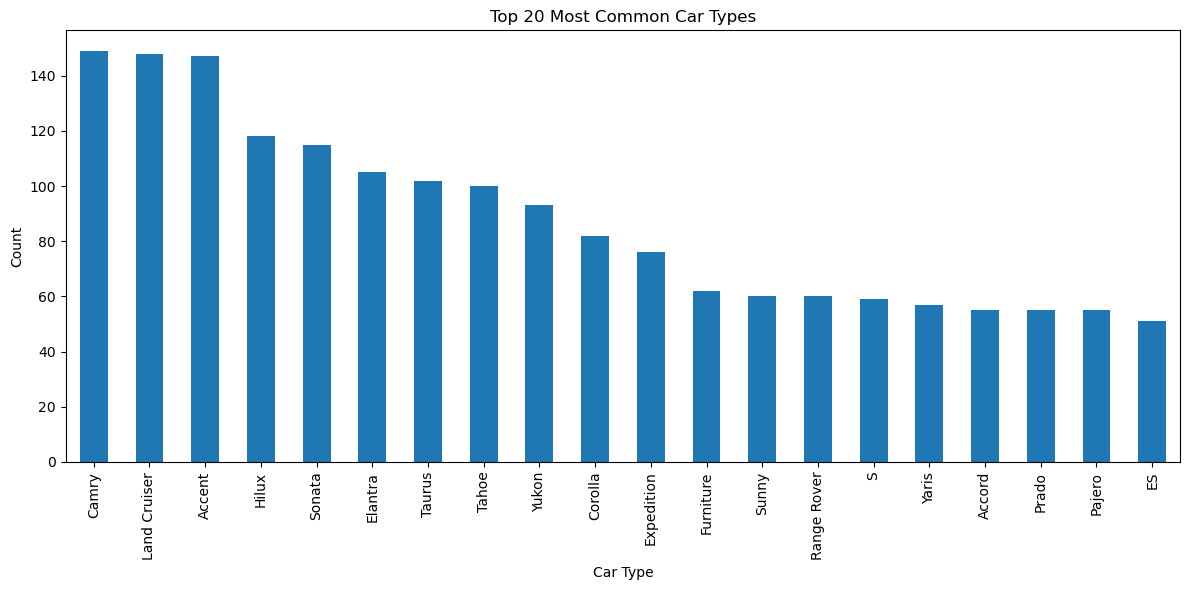


Top 20 most common Types:
Type
Camry           149
Land Cruiser    148
Accent          147
Hilux           118
Sonata          115
Elantra         105
Taurus          102
Tahoe           100
Yukon            93
Corolla          82
Expedition       76
Furniture        62
Sunny            60
Range Rover      60
S                59
Yaris            57
Accord           55
Prado            55
Pajero           55
ES               51
Name: count, dtype: int64


In [18]:
top_n_barplot(df['Type'], n=20, title='Top 20 Most Common Car Types', xlabel='Car Type')


Top 72 Types account for 80% of the data. 80th percentile: Other
These top 72 models represent 22.50% of all unique car types/models, and they represent 80.13% of all cars in the dataset.


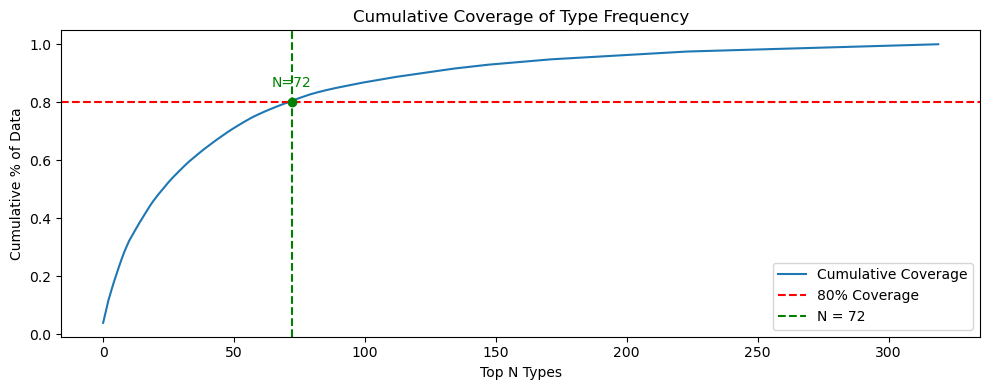

(72, 'Other')

In [26]:
pareto_coverage(df['Type'], target_pct=0.8)

In [27]:
rare_categories(df['Type'], threshold=10)

Rare Types (<10 rows): 238 of 320 total (74.38%)
Example rare values: Type
CX5        9
Acadia     9
Sorento    9
D-MAX      8
Duster     8
Name: count, dtype: int64


74% of car types in the dataset have less than 10 rows, which might be a limitation for the predictive model for these rare cars in the real-world dataset.

In [28]:
df[df['Type'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
445,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
602,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
804,Other,Dammam,Hyundai,Automatic,Other,Full,2011,4.6,270,False,30000
813,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
848,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1101,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500
1161,Other,Jeddah,Honda,Manual,Saudi,Standard,2011,1.0,4200,False,6500
1332,Other,Al-Medina,Mitsubishi,Manual,Saudi,Standard,2006,2.5,140000,False,45000
2421,Other,Riyadh,Geely,Automatic,Saudi,Full,2017,1.4,45000,False,36000
2471,Other,Khobar,Porsche,Automatic,Saudi,Full,2020,5.0,18000,False,375000


There is also an 'Other' value in Type, containing 13 rows of cars

#### 🔍 Feature Analysis: `Type` (Car Model)

- **Unique Types**: 320 (after removing negotiable and invalid price listings)
- **Top 20 Types**: Account for **45.74%** of all listings
- **Skewed Distribution**:  
  - **Top 72 models (22.5%)** already represent **80%** of the data
  - **238 out of 320 types (74%)** have **fewer than 10 rows**

> This shows a classic **long-tail distribution** where most models appear very rarely.

- **No typos or inconsistent casing/spacing** were detected
- There is a pre-existing `"Other"` value in the data with 13 rows.

#### ⚠️ Implications

- Model will learn best on common car types (e.g. Camry, Land Cruiser, Accent), but may underperform on rare types.
- For traditional models like linear regression or one-hot encoded baselines, might consider grouping rare types into a new label (e.g. `'Rare_Model'`) to reduce noise and feature sparsity.
- If using **CatBoost**, I can safely leave raw values (even rare ones), as it handles rare categories natively.

### Region

In [29]:
print("Unique Region count:", df['Region'].nunique())

Unique Region count: 27


In [30]:
find_near_duplicates(df['Region'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


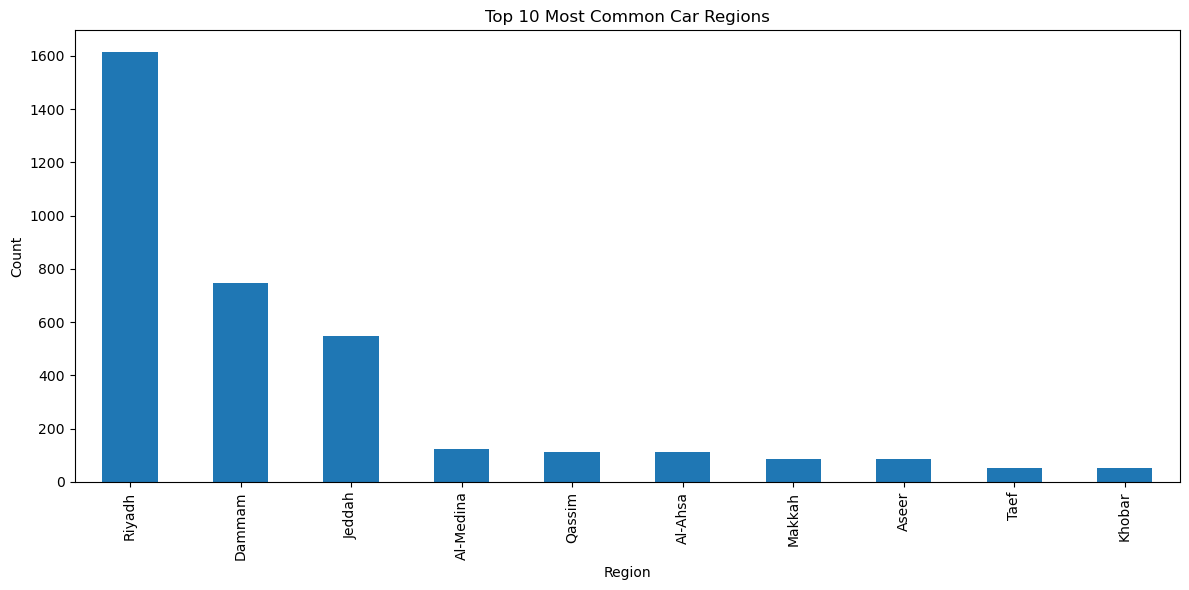


Top 20 most common Types:
Region
Riyadh       1615
Dammam        748
Jeddah        546
Al-Medina     124
Qassim        112
Al-Ahsa       111
Makkah         87
Aseer          87
Taef           53
Khobar         51
Name: count, dtype: int64


In [33]:
top_n_barplot(df['Region'], n=10, title='Top 10 Most Common Car Regions', xlabel='Region')


Top 5 Regions account for 80% of the data. 80th percentile: Qassim
These top 5 models represent 18.52% of all unique values in this feature, and they represent 82.24% of all cars in the dataset.


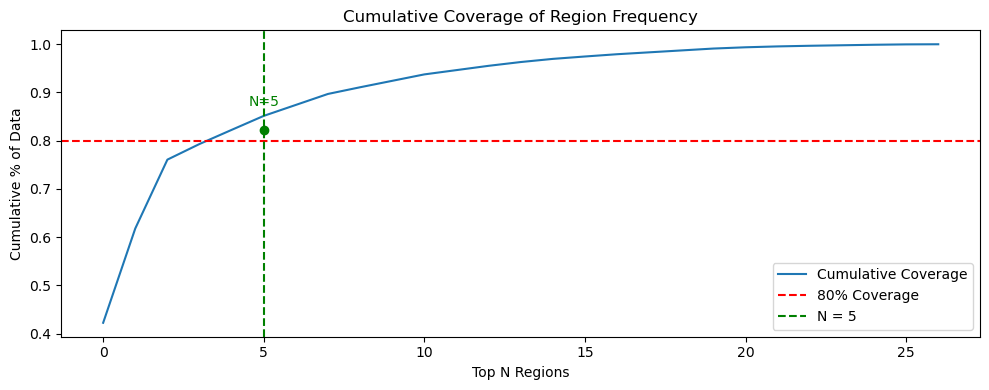

(5, 'Qassim')

In [36]:
pareto_coverage(df['Region'], target_pct=0.8)

In [37]:
rare_categories(df['Region'], threshold=10)

Rare Regions (<10 rows): 6 of 27 total (22.22%)
Example rare values: Region
Arar            7
Wadi Dawasir    5
Qurayyat        4
Sakaka          4
Besha           3
Name: count, dtype: int64


#### 🔍 Feature Analysis: `Region`

- **Unique Regions**: 27  
- **Top 5 Regions** (80% Pareto point):  
  1. Riyadh (1,615 listings, 42.3%)  
  2. Dammam (748, 19.6%)  
  3. Jeddah (546, 14.3%)  
  4. Al-Medina (124, 3.2%)  
  5. Qassim   (112, 2.9%)  
- **Coverage**: Top 5 regions (18.5% of all regions) account for **82.2%** of listings  
- **Rare Regions**: 6 regions (~22% of regions) have **<10 listings**  
  - Examples: Arar (7), Wadi Dawasir (5), Qurayyat (4), Sakaka (4), Besha (3), Sabya (1)  
- **Data Quality**: No typos or inconsistent naming detected  

#### ⚠️ Implications

- The model will learn best for the major hubs (Riyadh, Dammam, Jeddah).  
- Rare regions may need to be grouped into an “Other_Region” bucket or handled with robust encoders to avoid noisy estimates.  
- Geographic skew reflects actual market concentration, focus business insights on high-volume areas but be cautious interpreting low-volume regions.

### Make

In [38]:
print("Unique Make count:", df['Make'].nunique())

Unique Make count: 56


In [39]:
find_near_duplicates(df['Make'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


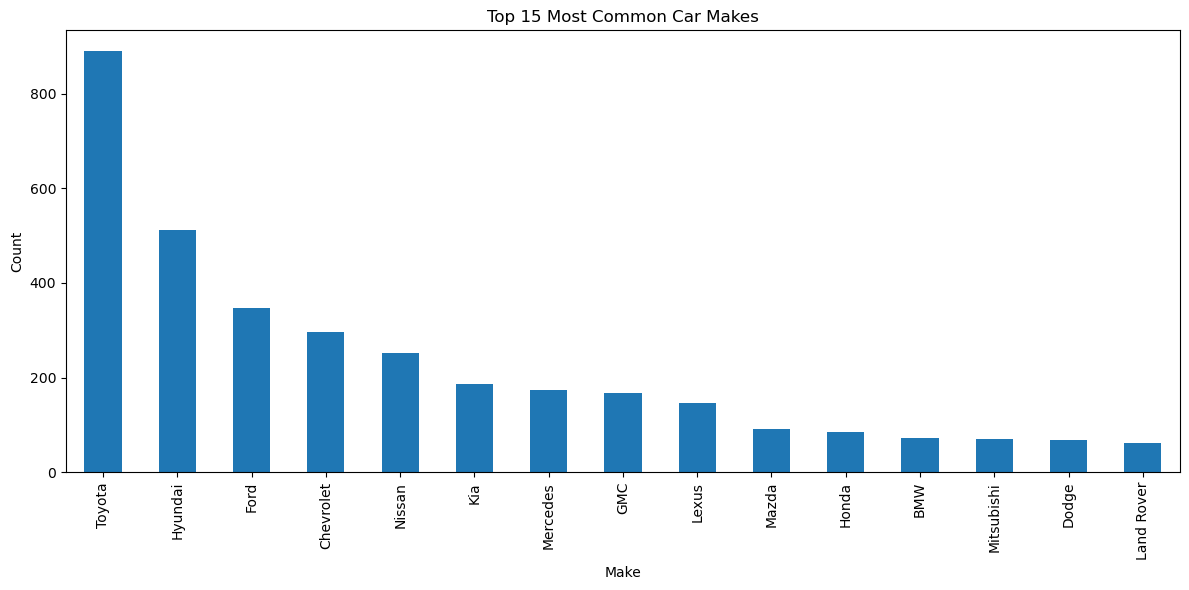


Top 20 most common Types:
Make
Toyota        889
Hyundai       512
Ford          346
Chevrolet     296
Nissan        252
Kia           186
Mercedes      173
GMC           167
Lexus         146
Mazda          92
Honda          85
BMW            72
Mitsubishi     71
Dodge          68
Land Rover     62
Name: count, dtype: int64


In [40]:
top_n_barplot(df['Make'], n=15, title='Top 15 Most Common Car Makes', xlabel='Make')


Top 11 Makes account for 80% of the data. 80th percentile: Honda
These top 11 models represent 19.64% of all unique values in this feature, and they represent 82.22% of all cars in the dataset.


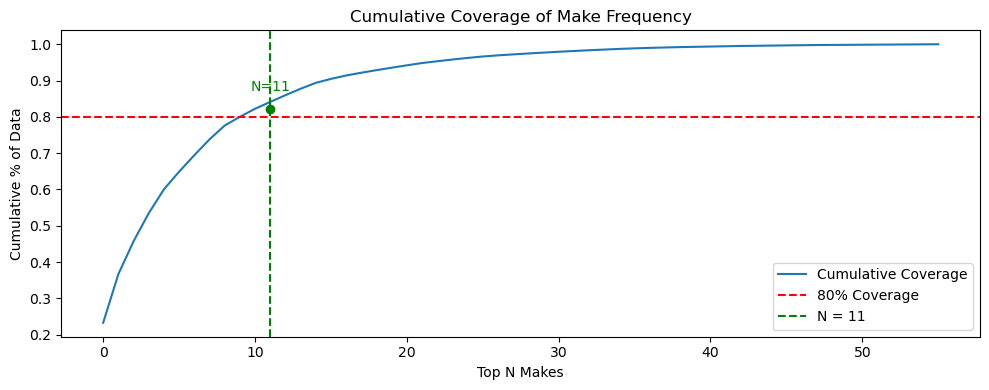

(11, 'Honda')

In [41]:
pareto_coverage(df['Make'], target_pct=0.8)

In [42]:
rare_categories(df['Make'], threshold=10)

Rare Makes (<10 rows): 27 of 56 total (48.21%)
Example rare values: Make
Lincoln    9
HAVAL      9
Jaguar     8
MINI       8
Peugeot    7
Name: count, dtype: int64


In [43]:
df[df['Make'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
445,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
602,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
813,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
848,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1101,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500


There is also an 'Other' value on `Make`, with 5 listings.

#### 🔍 Feature Analysis: `Make`

- **Unique Makes**: 56  
- **Top 5 Makes**:  
  1. Toyota (889 listings, 23.3%)  
  2. Hyundai (512, 13.4%)  
  3. Ford    (346, 9.1%)  
  4. Chevrolet (296, 7.8%)  
  5. Nissan   (252, 6.6%)  
- **Pareto Insight**:  
  - Top 11 makes (19.6% of all makes) cover **82.2%** of listings  
- **Long Tail**:  
  - 27 out of 56 makes (48.2%) have **<10 listings** (e.g. Lincoln, HAVAL, Jaguar)  
- **Raw “Other” Label**:  
  - There are 5 listings with `Make = "Other"` in the source data.

#### ⚠️ Implications

- The model will be strongest for common brands like Toyota and Hyundai, but may struggle or overfit on under-represented makes.  
- For one-hot or linear baselines, might need to group all makes with fewer than 10 observations into a `Rare_Make` category to improve stability and reduce dimensionality.
- With CatBoost (or similar), I can leave raw strings as these libraries handle rare categories natively.  

### Gear Type

In [44]:
print("Unique Gear Type count:", df['Gear_Type'].nunique())

Unique Gear Type count: 2


In [78]:
feature_value_counts(df['Gear_Type'])

Unique Gear_Type values: ['Automatic' 'Manual']
Gear_Type
Automatic    3420
Manual        404
Name: count, dtype: int64

Percentage breakdown:
Gear_Type
Automatic    89.44
Manual       10.56
Name: count, dtype: float64


For `Gear Type`, there are only 2 values: Automatic & Manual.

Most cars being listed on the website here is Automatic cars, with them representing almost 90% of listings.

In [46]:
find_near_duplicates(df['Gear_Type'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


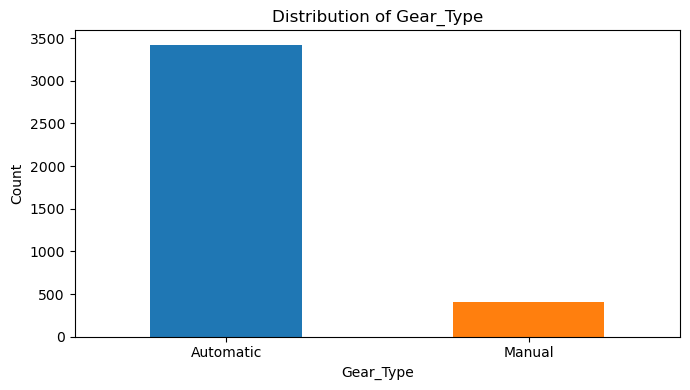

In [79]:
plot_categorical_distribution(df['Gear_Type'])

#### 🔍 Feature Analysis: `Gear_Type`

- **Unique Values**: 2 (`Automatic`, `Manual`)  
- **Counts**:  
  - Automatic: 3,420 listings (89.44%)  
  - Manual:    404 listings (10.56%)  
- **Data Quality**:  
  - No typos or inconsistent labels detected  

**Implications**

1. **Market Preference**  
   - The Saudi used-car market is overwhelmingly automatic, reflecting buyer demand and driving conditions.  
2. **Model Training**  
   - With only ~10% of cars manual, the model may have less exposure and produce noisier predictions for this subgroup.  
3. **Encoding Strategy**  
   - A simple binary encoding (0/1) is sufficient; no need for one-hot expansion beyond these two categories.  
4. **No Further Cleaning Needed**  
   - Since only valid categories exist and no rare values to group, we can proceed directly to modeling with this feature.  

## Origin

In [52]:
print("Unique Origin count:", df['Origin'].nunique())

Unique Origin count: 4


In [81]:
feature_value_counts(df['Origin'])

Unique Origin values: ['Saudi' 'Gulf Arabic' 'Other' 'Unknown']
Origin
Saudi          2893
Gulf Arabic     495
Other           420
Unknown          16
Name: count, dtype: int64

Percentage breakdown:
Origin
Saudi          75.65
Gulf Arabic    12.94
Other          10.98
Unknown         0.42
Name: count, dtype: float64


#### Handling `Unknown` in `Origin`

In the `Origin` column, I found a small subset of listings (16 rows) labeled as `"Unknown"`. This value likely indicates that the seller did not specify the car’s origin when listing it.

**Is `"Unknown"` just missing data?**

Yes from a data standpoint, it reflects **missing or undisclosed information**, not a meaningful car specification like "Saudi" or "Other". However, it can still carry business value.

**Why not merge `"Unknown"` into `"Other"`?**

While both differ from local (`Saudi`) or regional (`Gulf Arabic`) origins, `"Unknown"` and `"Other"` have **different meanings**:

| Origin         | Real-World Meaning                                                                 | Possible Buyer Perception / Price Reality in Data                        |
|----------------|-------------------------------------------------------------------------------------|------------------------------------------|
| `Saudi`        | Car originally sold in Saudi Arabia with GCC specs                                 | Most desirable: local specs, easy resale. Most common: lower median price (market baseline) |
| `Gulf Arabic`  | Imported from another GCC country (e.g. UAE, Kuwait)                               | Trusted, often premium imports; highest prices in data |
| `Other`        | Imported from outside GCC (e.g. US, Europe, Japan); often foreign-spec             | Least desirable: spec mismatch risk      |
| `Unknown`      | Seller did not disclose origin (left blank or chose "Not Sure")                   | Treated with caution: trust/risk penalty |

Merging them would hide this distinction and reduce the model’s ability to learn the subtle impact of **undisclosed origin** vs. **foreign origin**. If `"Unknown"` is merged with `"Other"`, we would unintentionally state that they are made/imported outside of GCC which has a completely different meaning unlike a normal "Other" value in other features.

**Decision: Keep `"Unknown"` as its own category**

- It allows the model to **learn the pricing penalty** associated with incomplete listings.
- It makes **interpretation easier**, especially with SHAP or business explanations.
- It **prepares the model for production**, where `"Unknown"` may continue to appear in new listings.

I will retain `"Unknown"` as a separate label throughout the pipeline (training, validation, and inference).

In [54]:
find_near_duplicates(df['Origin'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


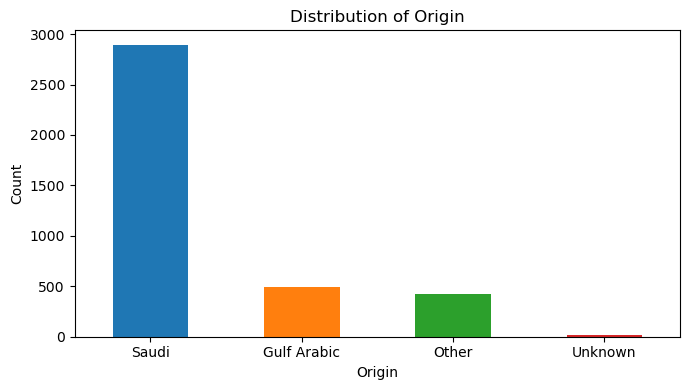

In [82]:
plot_categorical_distribution(df['Origin'])

Based on the filtered fixed-price listings, here’s what I observe:

**Key Takeaways**

1. **Gulf Arabic** cars have the **highest average and median prices**, with a wide spread and several high-end outliers.  
2. **Other** (non-GCC imports) sit in the middle—more expensive than local Saudi stock but less than Gulf Arabic.
3. **Saudi**-origin cars represent the bulk of the market and cluster around lower price points (median 55k SAR).  
4. **Unknown** listings (n=16) have the **lowest median price** but too few samples for strong conclusions.

> **Conclusion:** There is a clear step-up in price from Saudi → Other → Gulf Arabic, reflecting differing supply channels and buyer willingness to pay. "Unknown" listings underperform relative to all specified origins, suggesting possible information-gap discounts.

#### 🔍 Feature Analysis: `Origin`

**Unique Values:** 4 → `Saudi`, `Gulf Arabic`, `Other`, `Unknown`

| Origin         | Count | % of Data | Mean Price (SAR) | Median Price (SAR) |
|----------------|-------|-----------|------------------|--------------------|
| Saudi          | 2,893 | 75.7%     | 71,310           | 55,000             |
| Gulf Arabic    | 495   | 12.9%     | 112,519          | 86,000             |
| Other          | 420   | 11.0%     | 84,375           | 65,000             |
| Unknown        | 16    | 0.4%      | 56,938           | 42,250             |

**Business & Data Insights**

| Origin         | Meaning (Business)                                         | Buyer Perception & Price Signal (in Data)         |
|----------------|------------------------------------------------------------|---------------------------------------------------|
| **Saudi**      | Locally purchased, GCC specs                               | Most common; **lowest prices**, baseline market   |
| **Gulf Arabic**| Imported from another GCC country (UAE, Kuwait, etc.)      | Trusted, often premium; **highest prices in data**|
| **Other**      | Imported outside GCC (US, Europe, Asia); foreign spec      | Discounted due to risk/spec mismatch; **mid-range**|
| **Unknown**    | Seller did not specify origin (missing disclosure)         | Least trusted; **lowest prices, trust penalty**   |

**Implications for Modeling**

- **Gulf Arabic** cars fetch the highest prices, likely reflecting more premium imports.
- **Saudi** cars are most abundant but cluster at lower prices (market baseline).
- **Other** imports are discounted, as expected for non-local specs.
- **Unknown** receives the lowest prices, confirming a trust or information penalty.
- No typos or inconsistencies found; all values will be retained as-is.

**Bottom Line:**  
`Origin` is a strong price driver with real-world business meaning, clear data-backed segments, and will provide valuable predictive power to the model.


### Options

In [61]:
print("Unique Options count:", df['Options'].nunique())

Unique Options count: 3


In [ ]:
print("Unique Option values:", df['Options'].unique())
option_counts = df['Options'].value_counts()
print(option_counts)

# Percentage breakdown
option_percentages = (option_counts / option_counts.sum() * 100).round(2)
print(option_percentages)

Unique Option values: ['Full' 'Semi Full' 'Standard']
Options
Full         1473
Standard     1324
Semi Full    1027
Name: count, dtype: int64
Options
Full         38.52
Standard     34.62
Semi Full    26.86
Name: count, dtype: float64


In [63]:
find_near_duplicates(df['Options'])

Possible near-duplicate or inconsistent names:
Series([], dtype: object)


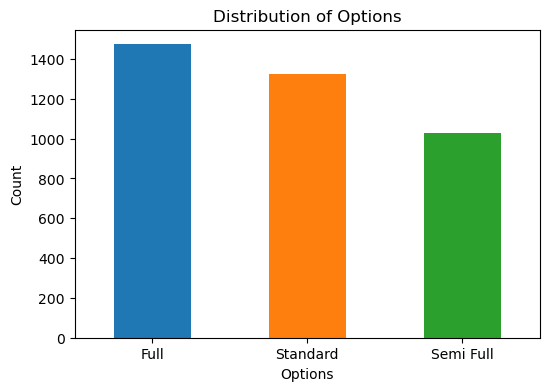

In [ ]:
plt.figure(figsize=(6,4))
option_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
option_counts.plot(kind='bar', color=option_colors)
plt.title('Distribution of Options')
plt.ylabel('Count')
plt.xlabel('Options')
plt.xticks(rotation=0)
plt.show()

#### 🔍 Feature Analysis: `Options` (Trim Level)

| Option     | Count | % of Listings |
|------------|-------|---------------|
| **Full**       | 1,473 | 38.52%        |
| **Standard**   | 1,324 | 34.62%        |
| **Semi Full**  | 1,027 | 26.86%        |

- **Data quality**: Only three clean, expected values, no typos or extras.

**Price Distribution by Options**

- **Median price** rises monotonically from **Standard → Semi Full → Full**.  
- **IQR** (75%–25% range) is largest for **Full**, reflecting a wider spread of luxury trims.  
- **High-end outliers** are most frequent in the **Full** category, underscoring premium variants.

**Implications**

1. **Business**  
   - "Full"‐trim cars command the highest prices due to luxury features (leather, sunroof, advanced safety).  
   - "Semi Full" occupies the middle tier, and "Standard" remains the entry level with the lowest prices.

2. **Modeling**  
   - We can treat `Options` as an **ordinal feature** (e.g. 0 = Standard, 1 = Semi Full, 2 = Full) to capture this monotonic effect.  
   - No grouping or merging needed, each level is well-represented and clearly ordered.

3. **Next steps**  
   - Encode as ordinal, then confirm that regression coefficients or SHAP values align with this trim gradient.  

## Numerical Features

### Year

What does the `Year` feature represent?

* **Business Meaning:**
  `Year` indicates the **production or registration year** of each car listing.

  * Newer cars are usually valued higher.
  * The feature is critical for depreciation modeling, understanding demand for recent vs. older models, and estimating car lifespan or maintenance needs.